In [2]:
import numpy as np
import gym

# Function to simulate CartPole environment and collect state-action pairs
def simulate_cartpole(num_samples):
    env = gym.make('CartPole-v1')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    state_action_pairs = []
    
    for _ in range(num_samples):
        state,_ = env.reset()
        done = False
        while not done:
            # Randomly choose an action
            action = env.action_space.sample()
            # Take action in the environment
            next_state, reward, terminated, done, _ = env.step(action)
            # Collect state-action pair
            state_action_pairs.append(np.concatenate([state, [action], next_state]))
            # Update current state
            state = next_state
        env.reset()  # Reset the environment after each episode
    
    env.close()
    return np.array(state_action_pairs)


# Simulate CartPole environment and collect state-action pairs
num_samples = 50  # Number of state-action pairs to collect
real_state_transition_data = simulate_cartpole(num_samples)
print(real_state_transition_data.shape)

# Save the collected real data to a file (optional)
np.save('real_state_transition_data.npy', real_state_transition_data)


(25000, 9)


In [3]:
print(np.sum(real_state_transition_data[:,4:5]))

12433.0


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error

# Define the CGAN model
class Generator(nn.Module):
    def __init__(self, latent_dim, input_dim, output_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.fc1 = nn.Linear(latent_dim + input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)
    
    def forward(self, z, c):
        x = torch.cat([z, c], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class Discriminator(nn.Module):
    def __init__(self,input_dim, output_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim + output_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, data, condition):
        x = torch.cat([data, condition], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [14]:
# Define the training parameters
latent_dim = 100
input_dim = 5  # Assuming state-action pairs
output_dim = 4  # Assuming state dimension
num_real_samples = 5000
num_test_samples = 200
batch_size = 50
num_epochs = 100

# Load real state transition data
real_state_transition_data = np.load('real_state_transition_data.npy')
test_state_transition_Data = real_state_transition_data[num_real_samples:(num_real_samples + num_test_samples)]
real_state_transition_data = real_state_transition_data[:num_real_samples] # shape: (num_real_samples, 9) state-action-next_state
real_data_loader = DataLoader(TensorDataset(torch.tensor(real_state_transition_data, dtype=torch.float32)), batch_size=batch_size, shuffle=True)

In [4]:
# Initialize CGAN models
generator = Generator(latent_dim, input_dim, output_dim)
discriminator = Discriminator(input_dim, output_dim)
optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)

# Train the CGAN model
for epoch in range(num_epochs):
    for real_data_batch, in real_data_loader:
        # training data for discriminator
        z = torch.randn(batch_size, latent_dim)
        c = real_data_batch[:, :input_dim]
        fake_data = generator(z, c).detach()
        real_data = real_data_batch[:, input_dim:]
        fake_labels = torch.zeros(batch_size, 1)
        real_labels = torch.ones(batch_size, 1)

        # Train the discriminator on real data
        optimizer_D.zero_grad()
        output_discriminator_real = discriminator(real_data, c)
        loss_discriminator_real = torch.mean((output_discriminator_real - real_labels) ** 2)
        loss_discriminator_real.backward()
        optimizer_D.step()

        # Train the discriminator on fake data
        optimizer_D.zero_grad()
        output_discriminator_fake = discriminator(fake_data, c)
        loss_discriminator_fake = torch.mean((output_discriminator_fake - fake_labels) ** 2)
        loss_discriminator_fake.backward()
        optimizer_D.step()

        # training data for generator
        z = torch.randn(batch_size, latent_dim)
        c = real_data_batch[:, :input_dim]

        # Train the generator
        optimizer_G.zero_grad()
        fake_data = generator(z, c)
        output_discriminator_fake = discriminator(fake_data, c)
        loss_generator = torch.mean((output_discriminator_fake - real_labels) ** 2)
        loss_generator.backward()
        optimizer_G.step()

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss_D_real: {loss_discriminator_real.item()}, Loss_D_fake: {loss_discriminator_fake.item()}, Loss_G: {loss_generator.item()}")    



Epoch: 0, Loss_D_real: 0.12204497307538986, Loss_D_fake: 0.039197999984025955, Loss_G: 1.1704894304275513
Epoch: 10, Loss_D_real: 0.10611255466938019, Loss_D_fake: 0.14335161447525024, Loss_G: 0.4621232748031616
Epoch: 20, Loss_D_real: 0.220466747879982, Loss_D_fake: 0.283323734998703, Loss_G: 0.4188762605190277
Epoch: 30, Loss_D_real: 0.07297713309526443, Loss_D_fake: 0.11214115470647812, Loss_G: 0.8484760522842407
Epoch: 40, Loss_D_real: 0.07712675631046295, Loss_D_fake: 0.07786531746387482, Loss_G: 0.7654063701629639
Epoch: 50, Loss_D_real: 0.16326799988746643, Loss_D_fake: 0.14747342467308044, Loss_G: 0.617938220500946
Epoch: 60, Loss_D_real: 0.06486881524324417, Loss_D_fake: 0.111526720225811, Loss_G: 0.6385338306427002
Epoch: 70, Loss_D_real: 0.1381663680076599, Loss_D_fake: 0.26790574193000793, Loss_G: 0.4397256374359131
Epoch: 80, Loss_D_real: 0.03619597852230072, Loss_D_fake: 0.18996110558509827, Loss_G: 0.484182208776474
Epoch: 90, Loss_D_real: 0.06990857422351837, Loss_D_fak

In [5]:
# save the model
torch.save(generator.state_dict(), 'cartpole_generator.pth')
torch.save(discriminator.state_dict(), 'cartpole_discriminator.pth')

In [16]:
# Generate test samples
test_z = torch.randn(num_test_samples, latent_dim)
test_state = torch.tensor(test_state_transition_Data[:, input_dim:], dtype=torch.float32)
test_state_action = torch.tensor(test_state_transition_Data[:, :input_dim], dtype=torch.float32)
# print(test_z.shape,test_state_action.shape,real_state_transition_data[num_real_samples:(num_real_samples + num_test_samples)])
generated_test_samples = generator(test_z, test_state_action)

# Calculate mean squared error (MSE)
mse = mean_squared_error(generated_test_samples.detach().numpy(), test_state.numpy())
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.0862494632601738


Slope: [0.9890502], Intercept: 0.03279244899749756


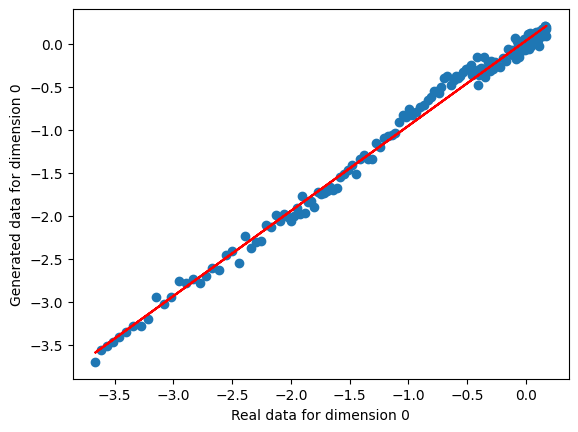

Slope: [1.0162897], Intercept: 0.015156686305999756


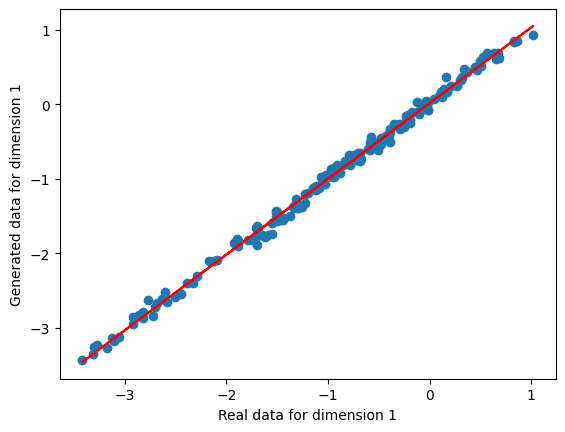

Slope: [1.0390943], Intercept: -0.17541217803955078


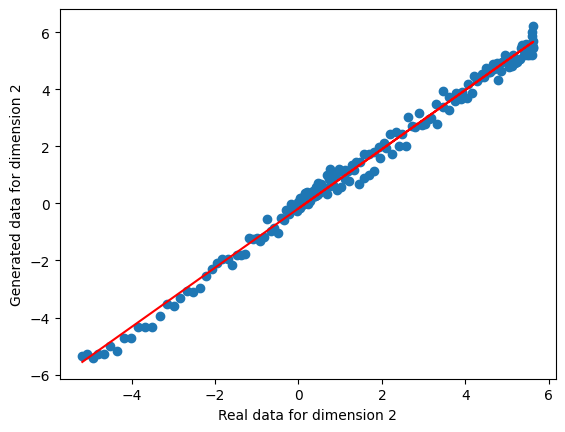

Slope: [1.0498303], Intercept: -0.1821751594543457


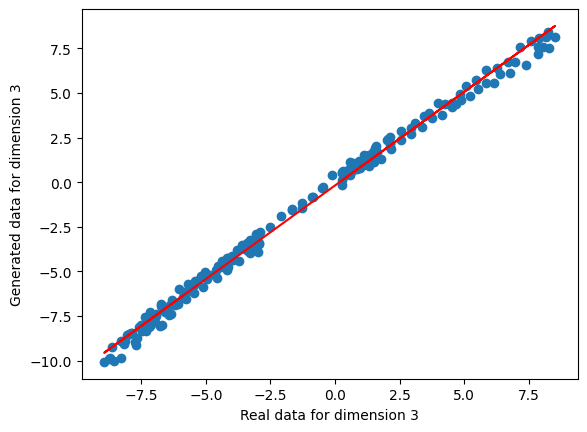

In [23]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
# generated_test_samples = generated_test_samples.detach().numpy()
for i in range(output_dim):
    real_data = test_state[:, i].numpy()
    generated_data = generated_test_samples[:, i]
    reg = LinearRegression().fit(real_data.reshape(-1, 1), generated_data)
    print(f"Slope: {reg.coef_}, Intercept: {reg.intercept_}")
    plt.scatter(real_data, generated_data)
    plt.plot(real_data, reg.predict(real_data.reshape(-1, 1)), color='red')
    plt.xlabel(f"Real data for dimension {i}")
    plt.ylabel(f"Generated data for dimension {i}")
    plt.show()
